**Общая информация**

**Срок сдачи:** 18 октября 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 18 октября, -4 балла после 06:00 25 октября, -6 баллов после 06:00 1 ноября

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (2 баллов)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

###### Задание 2 (2 балла)
Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy

###### Задание 3 (2 балла)
Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

###### Задание 4 (3 балла)
Добавить algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Значение n_neighbors нужно взять из задания 3. Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

###### Задание 5 (1 балла)
Описать для чего нужны следующие библиотеки/классы/функции (список будет ниже)

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять структуру кода и текст. В противном случае -1 балл


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree
#%load_ext pycodestyle_magic

In [2]:
#%%pycodestyle

class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin, ClassifierMixin):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.neighbors = n_neighbors
        self.algo = algorithm
    
    def fit(self, X, y):
        self.X = np.copy(X).astype(float)
        self.y = np.copy(y)
        self.classes = np.unique(y)
        self.n_classes = self.classes.shape[0]
        self.distanse_y = (self.X ** 2).sum(axis = 1)
    
    def predict(self, X):
        if self.algo == "brute":
            return self.solve_brute(X)
        elif self.algo == "kd_tree":
            return self.solve_kdtree(X)
        
    def predict_proba(self, X):
        if self.algo == 'brute':
            return self.solve_proba_brute(X)
        elif self.algo == 'kd_tree':
            return self.solve_proba_kdtree(X)
    
    def solve_brute(self, X):
        X = X.astype(float)
        distance_x = (X ** 2).sum(axis=1)
        distanse_x_y = X.dot(self.X.T) 
        # матрица *на столбец
        # (x^2 - y^2)
        dist = self.distanse_y - 2 * distanse_x_y + distance_x.reshape(-1, 1)
        new_distance = np.sqrt(dist) #вектор расстояний
        args = np.argsort(new_distance)
        predict = self.y[args[:, :self.neighbors]]
        # первые neigbours элементов в каждой строке
        return stats.mode(predict.T)[0].reshape(-1) 
        # берет из ModeResult mode = array и из двумерного делает одномерный
    
    def solve_proba_brute(self, X):
        X = X.astype(float)
        distance_x = (X ** 2).sum(axis=1)
        distanse_x_y = X.dot(self.X.T)
        dist = self.distanse_y - 2 * distanse_x_y + distance_x.reshape(-1, 1)
        new_distance = np.sqrt(dist)
        
        args = np.argsort(new_distance)
        nearest = args[:, :self.neighbors] #index K nearest
        predict = np.zeros((np.shape(X)[0], np.shape(self.classes)[0]))
        for i in range(np.shape(nearest)[0]):
            for j in nearest[i]:
                predict[i][int(self.y[j])] += 1
        return predict / self.neighbors

    def solve_kdtree(self, X):
        X = X.astype(float)
        tree = KDTree(self.X, leaf_size=50) #50 влияет на память, и на скорость: увеличивает
        _, ind = tree.query(X, k=self.neighbors) #возвращает значения и индексы
        predict = self.y[ind].T
        return stats.mode(predict)[0].reshape(-1)

    def solve_proba_kdtree(self, X): #вероятности попадания в класс, поэтому делим на 
        X = X.astype(float)
        tree = KDTree(self.X, leaf_size=50)
        _, near = tree.query(X, k=self.neighbors)
        
        predict = np.zeros((np.shape(X)[0], np.shape(self.classes)[0]))
        for i in range(np.shape(near)[0]):
            for j in near[i]:
                predict[i][int(self.y[j])] += 1
        return predict / self.neighbors

    def score(self, X, y):
        new_ans = np.subtract(self.predict(X), y)
        summ = np.count_nonzero(new_ans)
        return 1 - summ / y.shape[0]

**IRIS**

In [15]:
iris = datasets.load_iris()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [17]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [6]:
%time clf.fit(X_train, y_train)

CPU times: user 1.15 ms, sys: 239 µs, total: 1.39 ms
Wall time: 1.27 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [7]:
%time my_clf.fit(X_train, y_train)

CPU times: user 330 µs, sys: 197 µs, total: 527 µs
Wall time: 359 µs


In [8]:
%time clf.predict(X_test)

CPU times: user 1.15 ms, sys: 245 µs, total: 1.4 ms
Wall time: 1.31 ms


array([0, 0, 0, 1, 0, 2, 1, 1, 0, 2, 1, 2, 1, 2, 1])

In [9]:
%time my_clf.predict(X_test)

CPU times: user 3.63 ms, sys: 2.25 ms, total: 5.88 ms
Wall time: 3.96 ms


array([0, 0, 0, 1, 0, 2, 1, 1, 0, 2, 1, 2, 1, 2, 1])

In [10]:
%time clf.predict_proba(X_test)

CPU times: user 906 µs, sys: 202 µs, total: 1.11 ms
Wall time: 960 µs


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [11]:
%time my_clf.predict_proba(X_test)

CPU times: user 865 µs, sys: 847 µs, total: 1.71 ms
Wall time: 1.22 ms


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [12]:
clf.score(X_test, y_test)

0.9333333333333333

In [13]:
my_clf.score(X_test, y_test)

0.9333333333333333

Задание 3

Best number of neigbors is 9


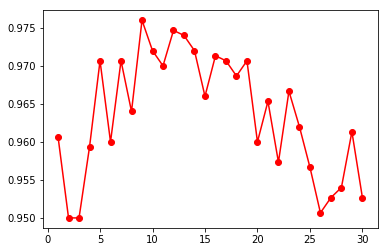

In [19]:
#%%pycodestyle
MAX_neighbors = 30
TESTS = 100
answer = []

for i in range(1, MAX_neighbors + 1):
    testing_results = []
    for j in range(TESTS):
        X_train, X_test, y_train, y_test = train_test_split(
            iris.data, iris.target,
            test_size=0.1, stratify=iris.target
        )
        my_clf = MyKNeighborsClassifier(n_neighbors=i)
        my_clf.fit(X_train, y_train)
        testing_results.append(my_clf.score(X_test, y_test))
    answer.append(np.mean(testing_results))

BESTS = np.argmax(answer) + 1
print("Best number of neigbors is {}".format(BESTS))

plt.plot(list(range(1, MAX_neighbors+1)), answer, 'ro-')
plt.show()

**MNIST**

In [3]:
mnist = fetch_mldata('MNIST original')

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.01, stratify=mnist.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [17]:
%time clf.fit(X_train, y_train)

CPU times: user 35.7 s, sys: 395 ms, total: 36.1 s
Wall time: 36.4 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [6]:
%time my_clf.fit(X_train, y_train)

CPU times: user 803 ms, sys: 676 ms, total: 1.48 s
Wall time: 1.53 s


In [19]:
%time clf.predict(X_test)

CPU times: user 57.9 s, sys: 240 ms, total: 58.1 s
Wall time: 58.4 s


array([9., 7., 4., 9., 9., 0., 2., 7., 8., 2., 7., 1., 4., 7., 7., 2., 7.,
       2., 6., 1., 0., 6., 6., 7., 5., 3., 8., 2., 1., 0., 5., 3., 3., 2.,
       2., 5., 9., 4., 2., 3., 4., 9., 3., 9., 4., 2., 4., 4., 1., 8., 7.,
       0., 1., 5., 8., 0., 9., 7., 1., 8., 0., 0., 5., 3., 0., 8., 1., 1.,
       7., 7., 1., 9., 0., 3., 5., 3., 1., 6., 5., 4., 7., 6., 7., 9., 9.,
       3., 8., 7., 1., 7., 4., 6., 8., 7., 9., 6., 0., 6., 6., 7., 3., 7.,
       9., 4., 4., 7., 3., 1., 4., 6., 6., 6., 5., 7., 1., 9., 1., 4., 1.,
       4., 4., 5., 7., 1., 9., 4., 5., 2., 7., 2., 9., 0., 4., 8., 9., 6.,
       5., 0., 3., 3., 6., 6., 0., 3., 6., 4., 2., 4., 1., 0., 0., 3., 1.,
       0., 8., 8., 0., 6., 6., 6., 9., 9., 6., 3., 6., 2., 7., 5., 2., 0.,
       4., 4., 6., 6., 7., 6., 7., 1., 4., 5., 2., 4., 1., 1., 3., 6., 5.,
       7., 7., 8., 8., 1., 8., 7., 0., 6., 9., 9., 6., 5., 3., 8., 6., 1.,
       4., 6., 3., 6., 5., 2., 0., 5., 9., 3., 1., 4., 0., 7., 5., 1., 7.,
       6., 0., 2., 0., 9.

In [20]:
%time my_clf.predict(X_test)

CPU times: user 8.88 s, sys: 2.08 s, total: 11 s
Wall time: 10.4 s


array([9., 7., 4., 9., 9., 0., 2., 7., 8., 2., 7., 1., 4., 7., 7., 2., 7.,
       2., 6., 1., 0., 6., 6., 7., 5., 3., 8., 2., 1., 0., 5., 3., 3., 2.,
       2., 5., 9., 4., 2., 3., 4., 9., 3., 9., 4., 2., 4., 4., 1., 8., 7.,
       0., 1., 5., 8., 0., 9., 7., 1., 8., 0., 0., 5., 3., 0., 8., 1., 1.,
       7., 7., 1., 9., 0., 3., 5., 3., 1., 6., 5., 4., 7., 6., 7., 9., 9.,
       3., 8., 7., 1., 7., 4., 6., 8., 7., 9., 6., 0., 6., 6., 7., 3., 7.,
       9., 4., 4., 7., 3., 1., 4., 6., 6., 6., 5., 7., 1., 9., 1., 4., 1.,
       4., 4., 5., 7., 1., 9., 4., 5., 2., 7., 2., 9., 0., 4., 8., 9., 6.,
       5., 0., 3., 3., 6., 6., 0., 3., 6., 4., 2., 4., 1., 0., 0., 3., 1.,
       0., 8., 8., 0., 6., 6., 6., 9., 9., 6., 3., 6., 2., 7., 5., 2., 0.,
       4., 4., 6., 6., 7., 6., 7., 1., 4., 5., 2., 4., 1., 1., 3., 6., 5.,
       7., 7., 8., 8., 1., 8., 7., 0., 6., 9., 9., 6., 5., 3., 8., 6., 1.,
       4., 6., 3., 6., 5., 2., 0., 5., 9., 3., 1., 4., 0., 7., 5., 1., 7.,
       6., 0., 2., 0., 9.

In [21]:
%time clf.predict_proba(X_test)

CPU times: user 59.1 s, sys: 292 ms, total: 59.4 s
Wall time: 59.9 s


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [7]:
%time my_clf.predict_proba(X_test)

CPU times: user 7.72 s, sys: 1.52 s, total: 9.24 s
Wall time: 7.88 s


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
clf.score(X_test, y_test)

0.9757142857142858

In [24]:
my_clf.score(X_test, y_test)

0.9757142857142858

Задание 4

In [8]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.01, stratify=mnist.target)

In [10]:
%time clf.fit(X_train, y_train)

CPU times: user 35 s, sys: 361 ms, total: 35.3 s
Wall time: 35.5 s


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [11]:
%time my_clf.fit(X_train, y_train)

CPU times: user 579 ms, sys: 394 ms, total: 973 ms
Wall time: 535 ms


In [29]:
%time clf.predict(X_test)

CPU times: user 57.1 s, sys: 126 ms, total: 57.3 s
Wall time: 57.4 s


array([0., 7., 2., 7., 6., 9., 5., 9., 0., 5., 7., 0., 7., 5., 5., 1., 1.,
       5., 0., 3., 1., 0., 1., 2., 3., 4., 1., 5., 1., 3., 5., 9., 2., 7.,
       0., 9., 5., 7., 3., 3., 9., 9., 0., 4., 8., 9., 4., 3., 1., 0., 7.,
       7., 9., 1., 8., 5., 4., 5., 9., 4., 9., 7., 3., 7., 9., 6., 5., 6.,
       9., 1., 6., 1., 8., 0., 4., 3., 4., 9., 3., 7., 4., 7., 8., 3., 7.,
       2., 4., 6., 1., 9., 4., 5., 7., 1., 3., 6., 4., 1., 5., 2., 1., 5.,
       1., 2., 8., 9., 1., 3., 2., 4., 1., 9., 3., 7., 4., 2., 6., 3., 9.,
       9., 2., 4., 6., 6., 4., 0., 8., 7., 2., 5., 5., 4., 8., 5., 7., 3.,
       1., 0., 6., 6., 1., 1., 6., 7., 0., 5., 3., 9., 8., 0., 8., 1., 1.,
       7., 1., 1., 0., 9., 4., 7., 5., 2., 4., 4., 5., 7., 9., 6., 0., 4.,
       7., 8., 1., 0., 7., 4., 3., 1., 7., 3., 1., 3., 2., 8., 5., 1., 2.,
       9., 9., 8., 3., 9., 2., 3., 8., 0., 0., 4., 8., 3., 3., 6., 0., 2.,
       0., 8., 2., 7., 3., 8., 2., 4., 0., 3., 9., 2., 0., 2., 3., 0., 1.,
       6., 3., 5., 5., 0.

In [49]:
%time my_clf.predict(X_test)

CPU times: user 1min 26s, sys: 648 ms, total: 1min 26s
Wall time: 1min 27s


array([0., 7., 2., 7., 6., 9., 5., 9., 0., 5., 7., 0., 7., 5., 5., 1., 1.,
       5., 0., 3., 1., 0., 1., 2., 3., 4., 1., 5., 1., 3., 5., 9., 2., 7.,
       0., 9., 5., 7., 3., 3., 9., 9., 0., 4., 8., 9., 4., 3., 1., 0., 7.,
       7., 9., 1., 8., 5., 4., 5., 9., 4., 9., 7., 3., 7., 9., 6., 5., 6.,
       9., 1., 6., 1., 8., 0., 4., 3., 4., 9., 3., 7., 4., 7., 8., 3., 7.,
       2., 4., 6., 1., 9., 4., 5., 7., 1., 3., 6., 4., 1., 5., 2., 1., 5.,
       1., 2., 8., 9., 1., 3., 2., 4., 1., 9., 3., 7., 4., 2., 6., 3., 9.,
       9., 2., 4., 6., 6., 4., 0., 8., 7., 2., 5., 5., 4., 8., 5., 7., 3.,
       1., 0., 6., 6., 1., 1., 6., 7., 0., 5., 3., 9., 8., 0., 8., 1., 1.,
       7., 1., 1., 0., 9., 4., 7., 5., 2., 4., 4., 5., 7., 9., 6., 0., 4.,
       7., 8., 1., 0., 7., 4., 3., 1., 7., 3., 1., 3., 2., 8., 5., 1., 2.,
       9., 9., 8., 3., 9., 2., 3., 8., 0., 0., 4., 8., 3., 3., 6., 0., 2.,
       0., 8., 2., 7., 3., 8., 2., 4., 0., 3., 9., 2., 0., 2., 3., 0., 1.,
       6., 3., 5., 5., 0.

In [13]:
%time clf.predict_proba(X_test)

CPU times: user 59.4 s, sys: 285 ms, total: 59.7 s
Wall time: 1min


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [12]:
%time my_clf.predict_proba(X_test)

CPU times: user 1min 20s, sys: 209 ms, total: 1min 20s
Wall time: 1min 20s


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [38]:
clf.score(X_test, y_test)

0.9685714285714285

In [39]:
my_clf.score(X_test, y_test)

0.9685714285714285

Задание 5

***seaborn***
  Библиотека, отснованная на matplotlib, для визуализации данных
  
***matplotlib***
  Библиотека для построения графиков 
  
***train_test_split***
  Разбитие данных на два массива: тренировочный и тестовый
  
***Pipelin%load_ext e (from sklearn.pipeline import Pipeline)***
  Конвейр для последовательного преобразования данных
  
***StandardScaler (from sklearn.preprocessing import StandardScaler)***
  Преобразование данных к нормальному виду:
  распределение имет среднее значение 0 и стандартное отклонение 1
  
***ClassifierMixin***
  Базовый класс для классификаторов sklearn
  
***NeighborsBase***
  Базовый класс для KNN из sklearn
  
***KNeighborsMixin*** 
  Базовый класс для KNN, содаржащий методы поиска соседей
  
***SupervisedIntegerMixin***
  Базовый класс, содержащий метод fit() для обучения